# London - Milestone Project
This project is based on a Kaggle dataset:
https://www.kaggle.com/edenau/london-bike-sharing-system-data

You actually have to retrieve to CSV files there **yourselves**!

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from haversine import haversine, Unit

In [38]:
# This won't work for you - at least not directly!
df_stations = pd.read_csv("data/stations.csv", index_col="Station ID")
df_journeys = pd.read_csv("data/journeys.csv")


In [39]:

df_stations.head()

,Capacity,Latitude,Longitude,Station Name
Station ID,,,,
1,19,51.529163,-0.109970,"River Street , Clerkenwell"
2,37,51.499606,-0.197574,"Phillimore Gardens, Kensington"
3,32,51.521283,-0.084605,"Christopher Street, Liverpool Street"
4,23,51.530059,-0.120973,"St. Chad's Street, King's Cross"
5,27,51.493130,-0.156876,"Sedding Street, Sloane Square"


#### London Coordinates
51.5074° N, 0.1278° W

Make sure to correctly convert **N** and **W** when using with a map.

### 1a) Plot Journey Durations
In your journey data, you have the journey duration for all trips. Play around with the plotting tools we talked about - do **journey durations depend on the time of day?**

<AxesSubplot:xlabel='Start Hour', ylabel='Journey Duration'>

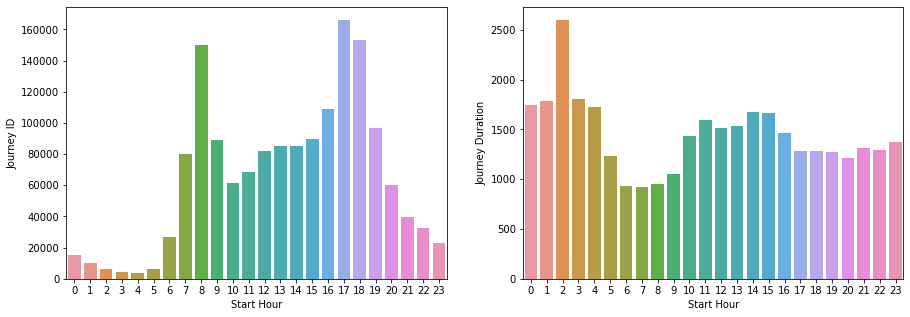

In [40]:
hourly_trips_count = df_journeys.groupby("Start Hour").count()
hourly_trips_mean = df_journeys.groupby("Start Hour").mean()
fig1, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,5))


sns.barplot(x=hourly_trips_count.index, y="Journey ID", data=hourly_trips_count,ax=ax1)
sns.barplot(x=hourly_trips_mean.index, y="Journey Duration", data=hourly_trips_mean,ax=ax2)



### 1b) Predict Journey Durations
You have lot's of information for the trip. Use just the data that is known at the beginning of the trip (i.e., start time and start station) to predict the journy duration. Use any regression model your a comfortable with.

In [41]:
X = df_journeys.drop("Journey Duration", axis=1)
y = df_journeys["Journey Duration"]


X.drop("Journey ID", axis=1, inplace=True)
#start_station = pd.get_dummies(X["End Station ID"], drop_first=True)
#stop_station = pd.get_dummies(X["Start Station ID"], drop_first=True)

X.drop(["End Station ID", "Start Station ID"], axis=1, inplace=True)



In [42]:
#X = pd.concat([X, stop_station, start_station], axis=1)



In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)






In [44]:

st_scaler = StandardScaler()
st_scaler.fit(X_train)
X_train_scaled = st_scaler.transform(X_train)

In [45]:
lin = LinearRegression()
lin.fit(X_train_scaled, y_train)


LinearRegression()

In [46]:
X_test_scaled = st_scaler.transform(X_test)

y_prediction = lin.predict(X_test_scaled)
np.sqrt(metrics.mean_squared_error(y_test, y_prediction))

18.91768797745577

### 2a) Stations
In the "Folium" Notebook, I showed you how to create a colored map with some data. Try to create a similar map using the number of stations in the different boroughs of London (provided as GeoJson in this folder)

In [47]:
m = folium.Map(location = [51.5074, -0.1278], zoom_start=12)

df_stations["stations"]  = list(zip(df_stations["Latitude"].round(4),df_stations["Longitude"].round(4)))
for index, row in df_stations.iterrows():
    folium.CircleMarker(radius=3, location=row["stations"], popup="Name: "+row["Station Name"]+" Capacity: "+str(row["Capacity"]), 
                                 color='green', fill_color='green').add_to(m)
    

    
    
    
m

### 2b) Coordinates
You know the stations' coordinates. Try to add two new columns to the journey DataFrame - Start Coordinate and End Coordinate

In [48]:
df_station_coordinates = df_stations.drop(["Capacity", "Station Name"],axis=1)
df_station_coordinates.rename(columns={"Latitude": "start_lat", "Longitude": "start_lng"},inplace=True)
df_station_coordinates.index.names = ['Start Station ID']
df_station_coordinates
df_journeys = pd.merge(df_journeys, df_station_coordinates, on="Start Station ID", how="left")

df_station_coordinates_end = df_stations.drop(["Capacity", "Station Name"],axis=1)
df_station_coordinates_end.rename(columns={"Latitude": "end_lat", "Longitude": "end_lng"},inplace=True)
df_station_coordinates_end.index.names = ['End Station ID']
df_journeys = pd.merge(df_journeys, df_station_coordinates_end, on="End Station ID", how="left")
df_journeys.dropna(inplace=True)

### 2c) Predict direction
Knowing the coordinate you can calculate it's distance to the city center (you just have to find out how!). Create two more columns in your journey DataFrame, Start Distance and End Distance. Based on these, create another column - direction - that indicates whether the journey is inbound (i.e., towards the city center), or outbound.
Use this column as target for a binary classification. As features, use only start time and start distance!

In [49]:
def distance_between_coordinates (trip_data,name):
    trip_data[name+"_distance"] = trip_data.apply(lambda row: haversine((row[name+"_lat"], row[name+"_lng"]),(51.5074, -0.1278),Unit.KILOMETERS), axis=1) 
    return trip_data

In [50]:
distance_between_coordinates(df_journeys,"start")
distance_between_coordinates(df_journeys,"end")

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,...,Start Minute,Start Station ID,start_lat,start_lng,stations_x,end_lat,end_lng,stations_y,start_distance,end_distance
0,2040.0,953,19,9,17,18,0,478,19,9,...,26,251,51.518908,-0.079249,"(51.5189, -0.0792)",51.521889,-0.046670,"(51.5219, -0.0467)",3.595196,5.840661
1,1800.0,12581,19,9,17,15,21,122,19,9,...,51,550,51.521564,-0.039264,"(51.5216, -0.0393)",51.521113,-0.078869,"(51.5211, -0.0789)",6.325765,3.713472
2,1140.0,1159,15,9,17,17,1,639,15,9,...,42,212,51.506584,-0.199004,"(51.5066, -0.199)",51.483570,-0.202038,"(51.4836, -0.202)",4.928860,5.782195
3,420.0,2375,14,9,17,12,16,755,14,9,...,9,163,51.493184,-0.167894,"(51.4932, -0.1679)",51.485121,-0.174971,"(51.4851, -0.175)",3.193920,4.098828
4,1200.0,14659,13,9,17,19,33,605,13,9,...,13,36,51.501737,-0.184980,"(51.5017, -0.185)",51.520331,-0.163667,"(51.5203, -0.1637)",4.007417,2.868391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542839,270.0,5296,8,8,17,0,2,32,7,8,...,58,42,51.530991,-0.093903,"(51.531, -0.0939)",51.524696,-0.084439,"(51.5247, -0.0844)",3.518808,3.563890
1542840,911.0,12348,8,8,17,0,13,625,7,8,...,58,222,51.502757,-0.155349,"(51.5028, -0.1553)",51.477619,-0.149551,"(51.4776, -0.1496)",1.975404,3.637810
1542841,447.0,8303,8,8,17,0,7,453,7,8,...,59,130,51.509506,-0.075459,"(51.5095, -0.0755)",51.508447,-0.055167,"(51.5084, -0.0552)",3.629963,5.028171
1542842,424.0,12038,8,8,17,0,6,405,7,8,...,59,755,51.485121,-0.174971,"(51.4851, -0.175)",51.494185,-0.182670,"(51.4942, -0.1827)",4.098828,4.072416


In [51]:
df_journeys["direction_to_citycenter"]= df_journeys["start_distance"]>df_journeys["end_distance"]
df_journeys

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,...,Start Station ID,start_lat,start_lng,stations_x,end_lat,end_lng,stations_y,start_distance,end_distance,direction_to_citycenter
0,2040.0,953,19,9,17,18,0,478,19,9,...,251,51.518908,-0.079249,"(51.5189, -0.0792)",51.521889,-0.046670,"(51.5219, -0.0467)",3.595196,5.840661,False
1,1800.0,12581,19,9,17,15,21,122,19,9,...,550,51.521564,-0.039264,"(51.5216, -0.0393)",51.521113,-0.078869,"(51.5211, -0.0789)",6.325765,3.713472,True
2,1140.0,1159,15,9,17,17,1,639,15,9,...,212,51.506584,-0.199004,"(51.5066, -0.199)",51.483570,-0.202038,"(51.4836, -0.202)",4.928860,5.782195,False
3,420.0,2375,14,9,17,12,16,755,14,9,...,163,51.493184,-0.167894,"(51.4932, -0.1679)",51.485121,-0.174971,"(51.4851, -0.175)",3.193920,4.098828,False
4,1200.0,14659,13,9,17,19,33,605,13,9,...,36,51.501737,-0.184980,"(51.5017, -0.185)",51.520331,-0.163667,"(51.5203, -0.1637)",4.007417,2.868391,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542839,270.0,5296,8,8,17,0,2,32,7,8,...,42,51.530991,-0.093903,"(51.531, -0.0939)",51.524696,-0.084439,"(51.5247, -0.0844)",3.518808,3.563890,False
1542840,911.0,12348,8,8,17,0,13,625,7,8,...,222,51.502757,-0.155349,"(51.5028, -0.1553)",51.477619,-0.149551,"(51.4776, -0.1496)",1.975404,3.637810,False
1542841,447.0,8303,8,8,17,0,7,453,7,8,...,130,51.509506,-0.075459,"(51.5095, -0.0755)",51.508447,-0.055167,"(51.5084, -0.0552)",3.629963,5.028171,False
1542842,424.0,12038,8,8,17,0,6,405,7,8,...,755,51.485121,-0.174971,"(51.4851, -0.175)",51.494185,-0.182670,"(51.4942, -0.1827)",4.098828,4.072416,True


### Extra - Revisit 1b)
Using not only the start time (and Station ID), but also the start distance (from city center), does your regression for journey durations improve?

### Extra - Plotting
We have been talking quite a bit about beautiful visualizations. Try to be creative and create some! 